### Assignment 02: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from random import randint
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

plt.style.use('dark_background')


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
BS = 128

train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=BS,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=BS,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

In [8]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [9]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(\
                                   nn.Linear(784, 256),
                                   nn.ReLU(),
                                   nn.Linear(256, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, 64),
                                   nn.ReLU(),
                                   nn.Linear(64, 10),
                                   nn.LogSoftmax(dim = 1)
                                  )
        
    def forward(self, inp):       
        out = self.model(inp)

In [10]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
              ReLU-6                   [-1, 64]               0
            Linear-7                   [-1, 10]             650
        LogSoftmax-8                   [-1, 10]               0
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.93
Estimated Total Size (MB): 0.94
----------------------------------------------------------------


In [11]:
TinyNeuralNetwork()

TinyNeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
    (7): LogSoftmax(dim=1)
  )
)

In [12]:
next(TinyNeuralNetwork().model.parameters()).is_cuda

False

In [13]:
TinyNeuralNetwork().to(device)

TinyNeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
    (7): LogSoftmax(dim=1)
  )
)

In [14]:
next(TinyNeuralNetwork().parameters()).is_cuda

False

Your experiments come here:

In [15]:
# Define the epochs
epochs = 30
model1 = TinyNeuralNetwork().model
model1 = model1.to(device)
optimizer = optim.Adam(model1.parameters(), lr = 0.002)
criterion = nn.NLLLoss()
train_losses1, test_losses1, accuracy_list1 = [], [], []

In [16]:
running_loss = 0
test_loss = 0
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Flatten Fashion-MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        images = images.to(device)
        labels = labels.to(device)
        
        # Training pass
        optimizer.zero_grad()
        output = model1.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        # Turn off gradients for validation, saves memory and computation
        with torch.no_grad():
          # Set the model to evaluation mode
          model1.eval()

    # Validation pass
    for images, labels in test_loader:
        images = images.view(images.shape[0], -1)
        
        images = images.to(device)
        labels = labels.to(device)
        
        log_ps = model1(images)
        test_loss += criterion(log_ps, labels)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model1.train()
    temp_train_loss = (running_loss/len(train_loader))
    temp_test_loss = test_loss/len(test_loader)
    temp_acc = accuracy/len(test_loader)
    
    train_losses1.append(temp_train_loss)
    test_losses1.append(temp_test_loss)
    accuracy_list1.append(temp_acc)
    
    print("Epoch: {}/{}..".format(e+1, epochs),
      "Training loss: {:.3f}..".format(temp_train_loss),
      "Test loss: {:.3f}..".format(temp_test_loss),
      "Test Accuracy: {:.3f}".format(temp_acc))

Epoch: 1/30.. Training loss: 0.560.. Test loss: 0.446.. Test Accuracy: 0.838
Epoch: 2/30.. Training loss: 0.378.. Test loss: 0.389.. Test Accuracy: 0.862
Epoch: 3/30.. Training loss: 0.341.. Test loss: 0.366.. Test Accuracy: 0.868
Epoch: 4/30.. Training loss: 0.315.. Test loss: 0.361.. Test Accuracy: 0.868
Epoch: 5/30.. Training loss: 0.297.. Test loss: 0.341.. Test Accuracy: 0.876
Epoch: 6/30.. Training loss: 0.287.. Test loss: 0.330.. Test Accuracy: 0.882
Epoch: 7/30.. Training loss: 0.270.. Test loss: 0.348.. Test Accuracy: 0.877
Epoch: 8/30.. Training loss: 0.258.. Test loss: 0.358.. Test Accuracy: 0.875
Epoch: 9/30.. Training loss: 0.249.. Test loss: 0.352.. Test Accuracy: 0.873
Epoch: 10/30.. Training loss: 0.242.. Test loss: 0.322.. Test Accuracy: 0.886
Epoch: 11/30.. Training loss: 0.232.. Test loss: 0.328.. Test Accuracy: 0.890
Epoch: 12/30.. Training loss: 0.227.. Test loss: 0.322.. Test Accuracy: 0.890
Epoch: 13/30.. Training loss: 0.221.. Test loss: 0.339.. Test Accuracy: 0

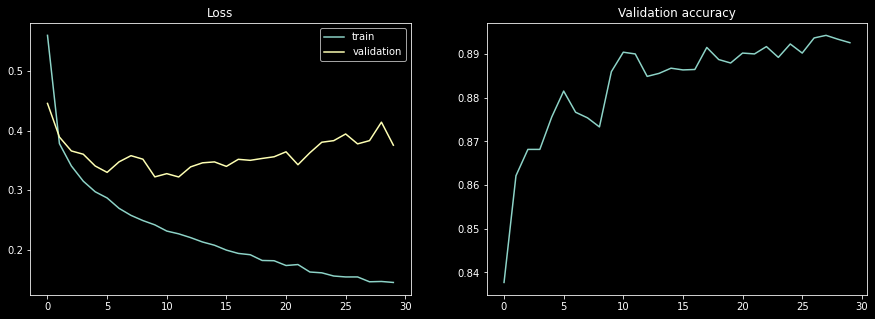

In [17]:
plot_train_process(train_losses1, test_losses1, accuracy_list1)

In [18]:
def test_proba_rand(model1):

    dataiter = iter(test_loader)
    images, labels = dataiter.next()
    img = images[randint(0, 100)]
    # Convert 2D image to 1D vector
    img = img.resize_(1, 784)

    img = img.to(device)
    # Calculate the class probabilities (softmax) for img
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model1(img)

    ps = torch.exp(logps)

    ps = ps.cpu()
    img = img.cpu()

    # Plot the image and probabilities
    view_classify(img.cpu().resize_(1, 28, 28), ps, version='Fashion');

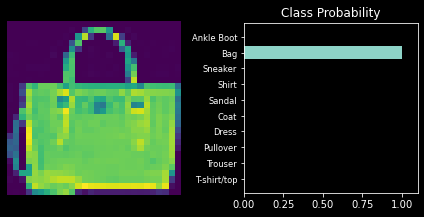

In [19]:
test_proba_rand(model1)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [20]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 6219563008
free     : 2432696320
used     : 3786866688


In [21]:
class FashionCNN2(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=500)
        self.fc3 = nn.Linear(in_features=500, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [22]:
model2 = FashionCNN2()
model2.to(device)
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
print(model2)

FashionCNN2(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=10, bias=True)
)


In [23]:
epochs = 30
count = 0
train_losses2, test_losses2, accuracy_list2 = [], [], []
predictions_list = []
labels_list = []

In [24]:
test_loss = 0
running_loss = 0
for e in range(epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        train = Variable(images.view(-1, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        log_ps = model2(train)
        loss = criterion(log_ps, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
        
        # Running loss
        running_loss += loss.item()
    
        count += 1
        
    else:
        test_loss = 0
        accuracy = 0
        # Turn off gradients for validation, saves memory and computation
        with torch.no_grad():
          # Set the model to evaluation mode
          model2.eval()
        
    # Testing the net
    total = 0
    correct = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)

        test = Variable(images.view(-1, 1, 28, 28))

        log_ps = model2(test)
        test_loss += criterion(log_ps, labels).item()
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
    model2.train()
    temp_train_loss = (running_loss/len(train_loader))**(-1)
    temp_test_loss = test_loss/len(test_loader)
    temp_acc = accuracy/len(test_loader)
    
    train_losses2.append(temp_train_loss)
    test_losses2.append(temp_test_loss)
    accuracy_list2.append(temp_acc)
    
    print("Epoch: {}/{}..".format(e+1, epochs),
      "Training loss: {:.3f}..".format(temp_train_loss),
      "Test loss: {:.3f}..".format(temp_test_loss),
      "Test Accuracy: {:.3f}".format(temp_acc))


Epoch: 1/30.. Training loss: 1.458.. Test loss: 0.461.. Test Accuracy: 0.835
Epoch: 2/30.. Training loss: 0.916.. Test loss: 0.379.. Test Accuracy: 0.864
Epoch: 3/30.. Training loss: 0.693.. Test loss: 0.346.. Test Accuracy: 0.877
Epoch: 4/30.. Training loss: 0.567.. Test loss: 0.335.. Test Accuracy: 0.880
Epoch: 5/30.. Training loss: 0.485.. Test loss: 0.321.. Test Accuracy: 0.883
Epoch: 6/30.. Training loss: 0.427.. Test loss: 0.302.. Test Accuracy: 0.895
Epoch: 7/30.. Training loss: 0.383.. Test loss: 0.294.. Test Accuracy: 0.894
Epoch: 8/30.. Training loss: 0.349.. Test loss: 0.285.. Test Accuracy: 0.899
Epoch: 9/30.. Training loss: 0.321.. Test loss: 0.276.. Test Accuracy: 0.902
Epoch: 10/30.. Training loss: 0.299.. Test loss: 0.270.. Test Accuracy: 0.902
Epoch: 11/30.. Training loss: 0.280.. Test loss: 0.267.. Test Accuracy: 0.904
Epoch: 12/30.. Training loss: 0.264.. Test loss: 0.269.. Test Accuracy: 0.900
Epoch: 13/30.. Training loss: 0.250.. Test loss: 0.264.. Test Accuracy: 0

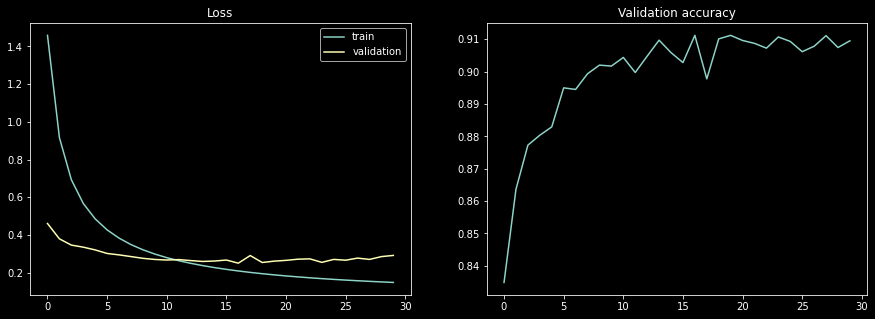

In [25]:
plot_train_process(train_losses2, test_losses2, accuracy_list2)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [44]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 6219563008
free     : 2132148224
used     : 4087414784


In [45]:
class FashionCNN3(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=100)
        self.drop = nn.Dropout2d(0.1)
        self.fc2 = nn.Linear(in_features=100, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [46]:
model3 = FashionCNN3()
model3.to(device)

criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)
print(model3)

FashionCNN3(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=100, bias=True)
  (drop): Dropout2d(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


In [47]:
epochs = 30
count = 0
# Lists for visualization of loss and accuracy 
train_losses3, test_losses3, accuracy_list3 = [], [], []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

In [48]:
test_loss = 0
running_loss = 0
for e in range(epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        train = Variable(images.view(-1, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        log_ps = model3(train)
        loss = criterion(log_ps, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
        
        # Running loss
        running_loss += loss.item()
    
        count += 1
        
    else:
        test_loss = 0
        accuracy = 0
        # Turn off gradients for validation, saves memory and computation
        with torch.no_grad():
          # Set the model to evaluation mode
          model3.eval()
        
    # Testing the net
    total = 0
    correct = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)

        test = Variable(images.view(-1, 1, 28, 28))

        log_ps = model3(test)
        test_loss += criterion(log_ps, labels).item()
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
    model3.train()
    temp_train_loss = (running_loss/len(train_loader))**(-1)
    temp_test_loss = test_loss/len(test_loader)
    temp_acc = accuracy/len(test_loader)
    
    train_losses3.append(temp_train_loss)
    test_losses3.append(temp_test_loss)
    accuracy_list3.append(temp_acc)
    
    print("Epoch: {}/{}..".format(e+1, epochs),
      "Training loss: {:.3f}..".format(temp_train_loss),
      "Test loss: {:.3f}..".format(temp_test_loss),
      "Test Accuracy: {:.3f}".format(temp_acc))


Epoch: 1/30.. Training loss: 1.708.. Test loss: 0.389.. Test Accuracy: 0.865
Epoch: 2/30.. Training loss: 1.078.. Test loss: 0.331.. Test Accuracy: 0.882
Epoch: 3/30.. Training loss: 0.820.. Test loss: 0.304.. Test Accuracy: 0.892
Epoch: 4/30.. Training loss: 0.674.. Test loss: 0.285.. Test Accuracy: 0.898
Epoch: 5/30.. Training loss: 0.577.. Test loss: 0.274.. Test Accuracy: 0.901
Epoch: 6/30.. Training loss: 0.508.. Test loss: 0.268.. Test Accuracy: 0.906
Epoch: 7/30.. Training loss: 0.457.. Test loss: 0.268.. Test Accuracy: 0.902
Epoch: 8/30.. Training loss: 0.417.. Test loss: 0.262.. Test Accuracy: 0.906
Epoch: 9/30.. Training loss: 0.384.. Test loss: 0.264.. Test Accuracy: 0.903
Epoch: 10/30.. Training loss: 0.357.. Test loss: 0.262.. Test Accuracy: 0.909
Epoch: 11/30.. Training loss: 0.335.. Test loss: 0.258.. Test Accuracy: 0.910
Epoch: 12/30.. Training loss: 0.316.. Test loss: 0.270.. Test Accuracy: 0.906
Epoch: 13/30.. Training loss: 0.300.. Test loss: 0.259.. Test Accuracy: 0

### Conclusions:

Steps for reducing overfitting:
- Add more data
- Use data augmentation
- Use architectures that generalize well
- Add regularization
- Reduce architecture complexity.

The three training processes are displayed below. In case of the simple linear network, overfittin practically starts straight away. Because in the case of only linear layers you have millions of parameters straight. The convolution allows for a enormous model reduction

In case of the second model, I have made a huge model with a significant amount of parameters. Not using dropout nor regularlization. Therefore, as you can see in the two plots below (loss2 vs loss3), it is not untill epoch 10 that the second model train set falls below the validation set.

When reducing model complexity, adding regularization and dropout, the third model train loss function drops below the vlidation set after epoch 15. This all happens with equivalent parameters, and the accuracy of the final model climbs faster than the second model.

Therefore, model 3 is the preferred model.

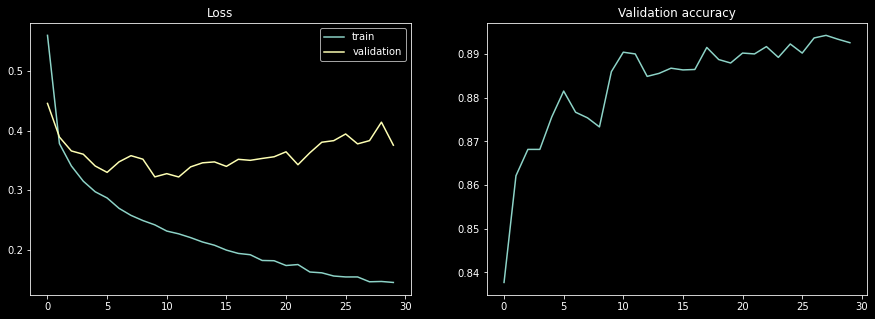

In [49]:
plot_train_process(train_losses1, test_losses1, accuracy_list1)

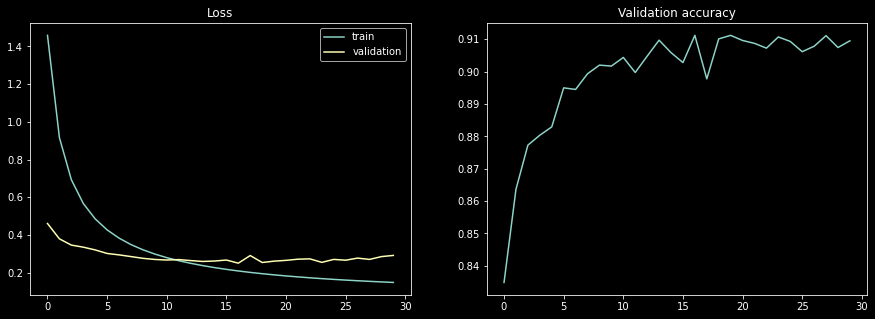

In [50]:
plot_train_process(train_losses2, test_losses2, accuracy_list2)

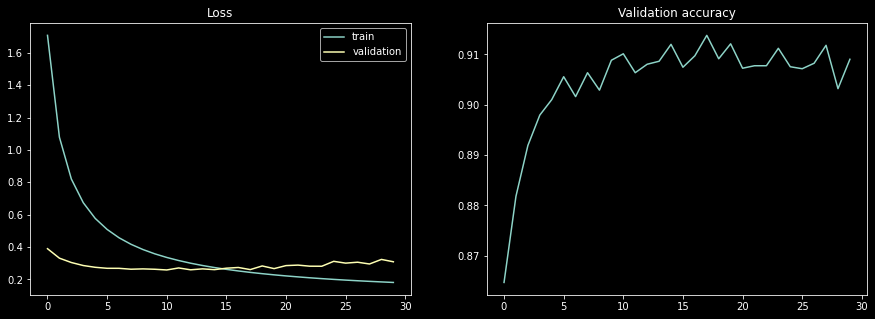

In [51]:
plot_train_process(train_losses3, test_losses3, accuracy_list3)